<a href="https://colab.research.google.com/github/DiegoDelgadoD/Intermediate-Python-/blob/main/PC_Causal_Tree_Forest_ddd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Causal Trees

*How to use regression trees to estimate heterogeneous treatment effects.*

In causal inference we are usually interested in estimating the causal effect of a treatment (a drug, ad, product, ...) on an outcome of interest (a disease, firm revenue, customer satisfaction, ...). However, knowing that a treatment works on average is often not sufficient and we would like to know for which subjects (patients, users, customers, ...) it works better or worse, i.e. we would like to estimate **heterogeneous treatment effects**.

Estimating heterogeneous treatments effects allows us to do **targeting**. Knowing which customers are more likely to react to a discount allows a company to spend less money by offering fewer but better targeted discounts. This works also for negative effects: knowing for which patients a certain drug has side effects allows a pharmaceutical company to warn or exclude them from the treatment. There is also a more subtle advantage of estimating heterogeneous treatment effects: knowing **for whom** a treatment works allows us to better understand **how** a treatment works. Knowing that the effect of a discount does not depend on the income of its recipient but rather by its buying habits  tells us that maybe it is not a matter of money, but rather a matter of attention or loyalty.

In this article, we will explore the estimation of heterogeneous treatment effects using a modified version of regression trees (and forests). From a machine learning perspective, there are two fundamental **differences between causal trees and predictive trees**. First of all, the target is the treatment effect, which is an inherently unobservable object. Second, we are interested in doing inference, which means quantifying the uncertainty of our estimates.

## Online Discounts

For the rest of the article, we are going to use a toy example, for the sake of exposition: suppose we were an **online shop** and we are interested in understanding whether offering discounts to new customers increases their expenditure. In particular, we would like to know if offering discounts is more effective for some customers with respect to others, since we would prefer not to give discounts to customers that would spend anyways. Moreover, it could also be that spamming customers with pop-ups could deter them from buying, having the opposite effect.



To understand whether and how much the discounts are effective we run an **A/B test**: whenever a new user visits our online shop, we randomly decide whether to offer them the discount or not. I import the data-generating process `dgp_online_discounts()` from [`src.dgp`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/dgp.py). With respect to previous articles, I generated a new DGP parent class that handles randomization and data generation, while its children classes contain specific use cases. I also import some plotting functions and libraries from [`src.utils`](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/src/utils.py). To include not only code but also data and tables, I use [Deepnote](https://deepnote.com/), a Jupyter-like web-based collaborative notebook environment.

[texto del vínculo](https://)### This script is based on the work of Matteo Courthoud
Reference: [Link](https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/causal_trees.ipynb)

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('seaborn')
sns.set_theme(style="ticks")
mpl.rcParams['figure.figsize'] = (10,6)

# Title
mpl.rcParams['figure.titlesize'] = 22
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = 22
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 20

# Axes labels
mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['axes.labelweight'] = 'bold'

# Grid and thicks
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = True
mpl.rcParams['axes.grid.axis'] = 'y'
#mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['ytick.left'] = False

# Legend
mpl.rcParams['legend.facecolor'] = 'w'
mpl.rcParams['legend.title_fontsize'] = 14
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 1
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.facecolor'] = 'white'
mpl.rcParams['legend.edgecolor'] = 'gray'
mpl.rcParams['legend.borderpad'] = 0.6

# Other
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['scatter.edgecolors'] = "black"




In [ ]:
class DGP:
    n: int = 100000
    p: int = 0.5

    def __post_init__(self):
        self.df = self.generate_potential_outcomes()

    def generate_baseline(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframes with the baseline outcome."""
        return pd.DataFrame()

    def add_treatment_effect(self, df : pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Add the treatment effect to the baseline outcome."""
        return pd.DataFrame

    def generate_potential_outcomes(self, seed: int = 0) -> pd.DataFrame:
        """Generates a dataframes with treatment and control potential outcomes."""
        df = self.generate_baseline(seed)
        df = self.add_treatment_effect(df, seed)
        for y in self.Y:
            df[y + '_t'] = df[y + '_c'] + df['effect_on_' + y]
            del df['effect_on_' + y]
        return df.round(2)

    def add_assignment(self, df: pd.DataFrame, seed: int = 0) -> pd.DataFrame:
        """Adds the treatment assignment variable."""
        np.random.seed(seed)
        df[self.D] = np.random.binomial(1, self.p, self.n)
        return df

    def generate_data(self, seed_data: int = 0, seed_assignment: int = 1, **kwargs) -> pd.DataFrame:
        """Generate potential outcomes, add assignment and select realized outcomes."""
        df = self.generate_potential_outcomes(seed_data, **kwargs)
        df = self.add_assignment(df, seed_assignment)
        d = df[self.D].values
        for y in self.Y:
            df[y] = df[y + '_c'].values * (1-d) + df[y + '_t'].values * d
            del df[y + '_c']
            del df[y + '_t']
        return df

    def evaluate_f_redrawing_data(self, f, K):
        """Evaluates the function f on K draws of the data (both potential outcomes and treatment assignment)."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_data=i, seed_assignment=K-i)) for i in range(K))
        return results

    def evaluate_f_redrawing_outcomes(self, f, K):
        """Evaluates the function f on K draws of the treatment assignment. Potential outcomes are fixed."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_data(seed_assignment=i)) for i in range(K))
        return results

    def evaluate_f_redrawing_potentialoutcomes(self, f, K):
        """Evaluates the function f on K draws of the potential outcomes."""
        results = Parallel(n_jobs=8)(delayed(f)(self.generate_potential_outcomes(seed_data=i)) for i in range(K))
        return results



In [ ]:
class dgp_online_discounts(DGP):
    """DGP: online discounts"""
    devices = ['desktop', 'mobile']
    browsers = ['chrome', 'safari', 'firefox', 'explorer', 'edge', 'brave', 'other']
    regions = [str(x) for x in range(10)]
    X: list[str] = ['time', 'device', 'browser', 'region']
    D: str = 'discount'
    Y: list[str] = ['spend']

    def generate_baseline(self, seed:int = 0):
        np.random.seed(seed)
        time = np.random.beta(1, 1, size=self.n) * 24
        device = np.random.choice(self.devices, size=self.n)
        browser = np.random.choice(self.browsers, size=self.n)
        region = np.random.choice(self.regions, size=self.n)
        spend_c = np.random.exponential(10, self.n) - 5
        df = pd.DataFrame({'spend_c': spend_c, 'time': time, 'device': device, 'browser': browser, 'region': region})
        return df

    def add_treatment_effect(self, df, seed:int = 0):
        np.random.seed(seed)
        effect = 7*np.exp(-(df.time-18)**2/100) + 3*(df.browser=='safari') - 2*(df.device=='desktop') + (df.region=='3')
        df['effect_on_spend'] = np.maximum(0, effect)
        return df

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dgp = dgp_online_discounts()
df = dgp.generate_data()
df.head()

,time,device,browser,region,discount,spend
0,10.78,mobile,edge,9,0,0.46
1,0.57,desktop,firefox,9,1,11.04
2,3.74,mobile,safari,7,0,1.81
3,13.37,desktop,other,5,0,31.90
4,0.71,mobile,explorer,2,0,15.42


In [ ]:
dgp.Y

['spend']

In [ ]:
df[dgp.Y]

,spend
0,0.46
1,11.04
2,1.81
3,31.90
4,15.42
...,...
99995,38.12
99996,17.95
99997,14.84
99998,0.20


In [ ]:
dgp.generate_data()

,time,device,browser,region,discount,spend
0,10.78,mobile,edge,9,0,0.46
1,0.57,desktop,firefox,9,1,11.04
2,3.74,mobile,safari,7,0,1.81
3,13.37,desktop,other,5,0,31.90
4,0.71,mobile,explorer,2,0,15.42
...,...,...,...,...,...,...
99995,14.22,desktop,firefox,9,1,38.12
99996,15.80,desktop,other,5,1,17.95
99997,2.36,desktop,safari,9,1,14.84
99998,3.72,desktop,edge,4,1,0.20


In [ ]:
df.discount.value_counts()

discount
0    50014
1    49986
Name: count, dtype: int64

<Axes: >

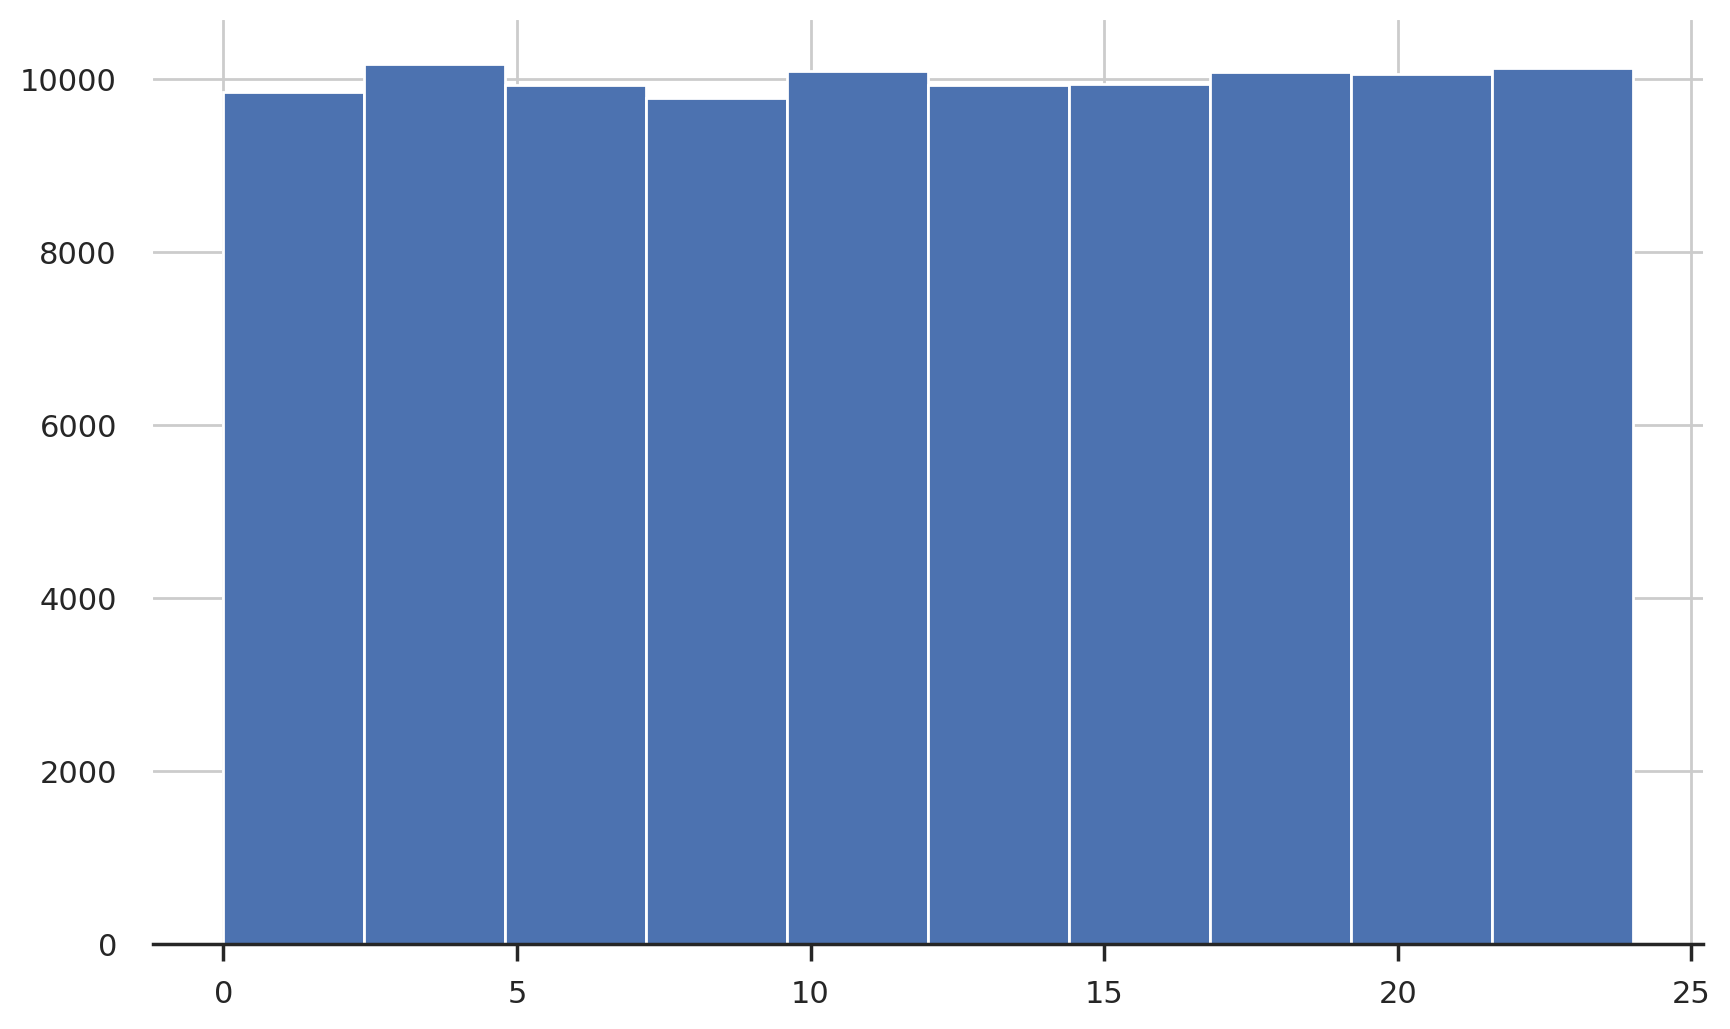

In [ ]:
df.time.hist()


We have data on 100.000 website visitors, for whom we observe the `time` of the day, the `device` they use, their `browser` and their geographical `region`. We also see whether they were offered the `discount`, our treatment, and what is their `spend`, the outcome of interest.

Since the treatment was randomly assigned, we can use a simple **difference-in-means** estimator to estimate the treatment effect. We expect the treatment and control group to be similar, except for the `discount`, therefore we can causally attribute any difference in `spend` to the `discount`.

In [ ]:
 D: str = 'discount'
    Y: list[str] = ['spend']
smf.ols('spend ~ discount', df).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,5.0306,0.046,109.949,0.000,4.941,5.120
discount,3.8568,0.065,59.597,0.000,3.730,3.984


The discount seems to be effective: on average the spend in the treatment group increases by 3.86$. But are all customers equally affected?

To answer this question, we would like to estimate **heterogeneous treatment effects**, possibly at the individual level.

## Conditional Average Treatment Effects

There are many possible ways to estimate heterogenous treatment effects. The most common is to split the population in groups based on some observable characteristic, which in our case could be the `device`, the `browser` or the geographical `region`. Splitting is easy for categorical variables, but for a continuous variable like `time` it is not intuitive where to split. Every hour? And which dimension is more informative? It would be temping to try all possible splits, but the more we split the data, the more it is likely that we find spurious results (i.e. we overfit, in machine learning lingo). It would be great if we could **let the data speak** and select the minimum and most informative splits.

The idea is to predict the outcome conditional on the treatment status for each observation, and then compare the predicted conditional on treatment, with the predicted outcome conditional on control. The difference is the individual treatment effect.

The problem with meta-learners is that they use all their [degrees of freedom](https://en.wikipedia.org/wiki/Degrees_of_freedom_(statistics)) in predicting the outcome. However, we are interested to predict treatment effect heterogeneity. If most of the variation in the outcome is *not* in the treatment dimension, we will get very poor estimates of the treatment effects.

Is it possible to instead directly concentrate on the **prediction of individual treatment effects**? Let's define $Y$ the outcome of interest, `spend` in our case, $D$ the treatment, the `discount`, and $X$ other observable characteristics. The *ideal* objective function is

$$
\sum_i \Big [ ( \tau_i - \hat \tau_i(X))^2 \Big ]
$$

where $\tau_i$ is the treatment effect of individual $i$. However, this objective function is **unfeasible** since we do not observe $\tau_i$.

But, turns out that there is a way to get an unbiased estimate of the **individual treatment effect**. The **idea** is to use an auxiliary outcome variable, whose expected value for each individual is the individual treatment effect. This variable is

$$
Y_i^* = \frac{Y_i}{D_i \cdot p(X_i) - (1-D_i) \cdot (1-p(X_i))}
$$

where $p(X_i)$ is the [**propensity score**](https://en.wikipedia.org/wiki/Propensity_score_matching) of observation $i$, i.e. its probability of being treated.

In randomized experiments, the propensity score is known since randomization is fully under control of the experimenter. For example, in our case, the probability of treatment was 50\%. In quasi-experimental studies instead, when the treatment probability is not known, it has to be estimated. Even in randomized experiments, it is always better to estimate rather than inpute the propensity scores, since it guards against sampling variation in the randomization.


Let's first generate dummy variables for our categorical variables, `device`, `browser` and `region`.

In [ ]:
dgp.X[1:]

['device', 'browser', 'region']

In [ ]:
df_dummies = pd.get_dummies(df[dgp.X[1:]], drop_first=True)
df_dummies
df = pd.concat([df, df_dummies], axis=1)
X = ['time'] + list(df_dummies.columns)

In [ ]:
len(X)

17

In [ ]:
df.columns

Index(['time', 'device', 'browser', 'region', 'discount', 'spend',
       'device_mobile', 'browser_chrome', 'browser_edge', 'browser_explorer',
       'browser_firefox', 'browser_other', 'browser_safari', 'region_1',
       'region_2', 'region_3', 'region_4', 'region_5', 'region_6', 'region_7',
       'region_8', 'region_9'],
      dtype='object')

We fit a `LogisticRegression` and use it to predict the treatment probability, i.e. construct the propensity score.

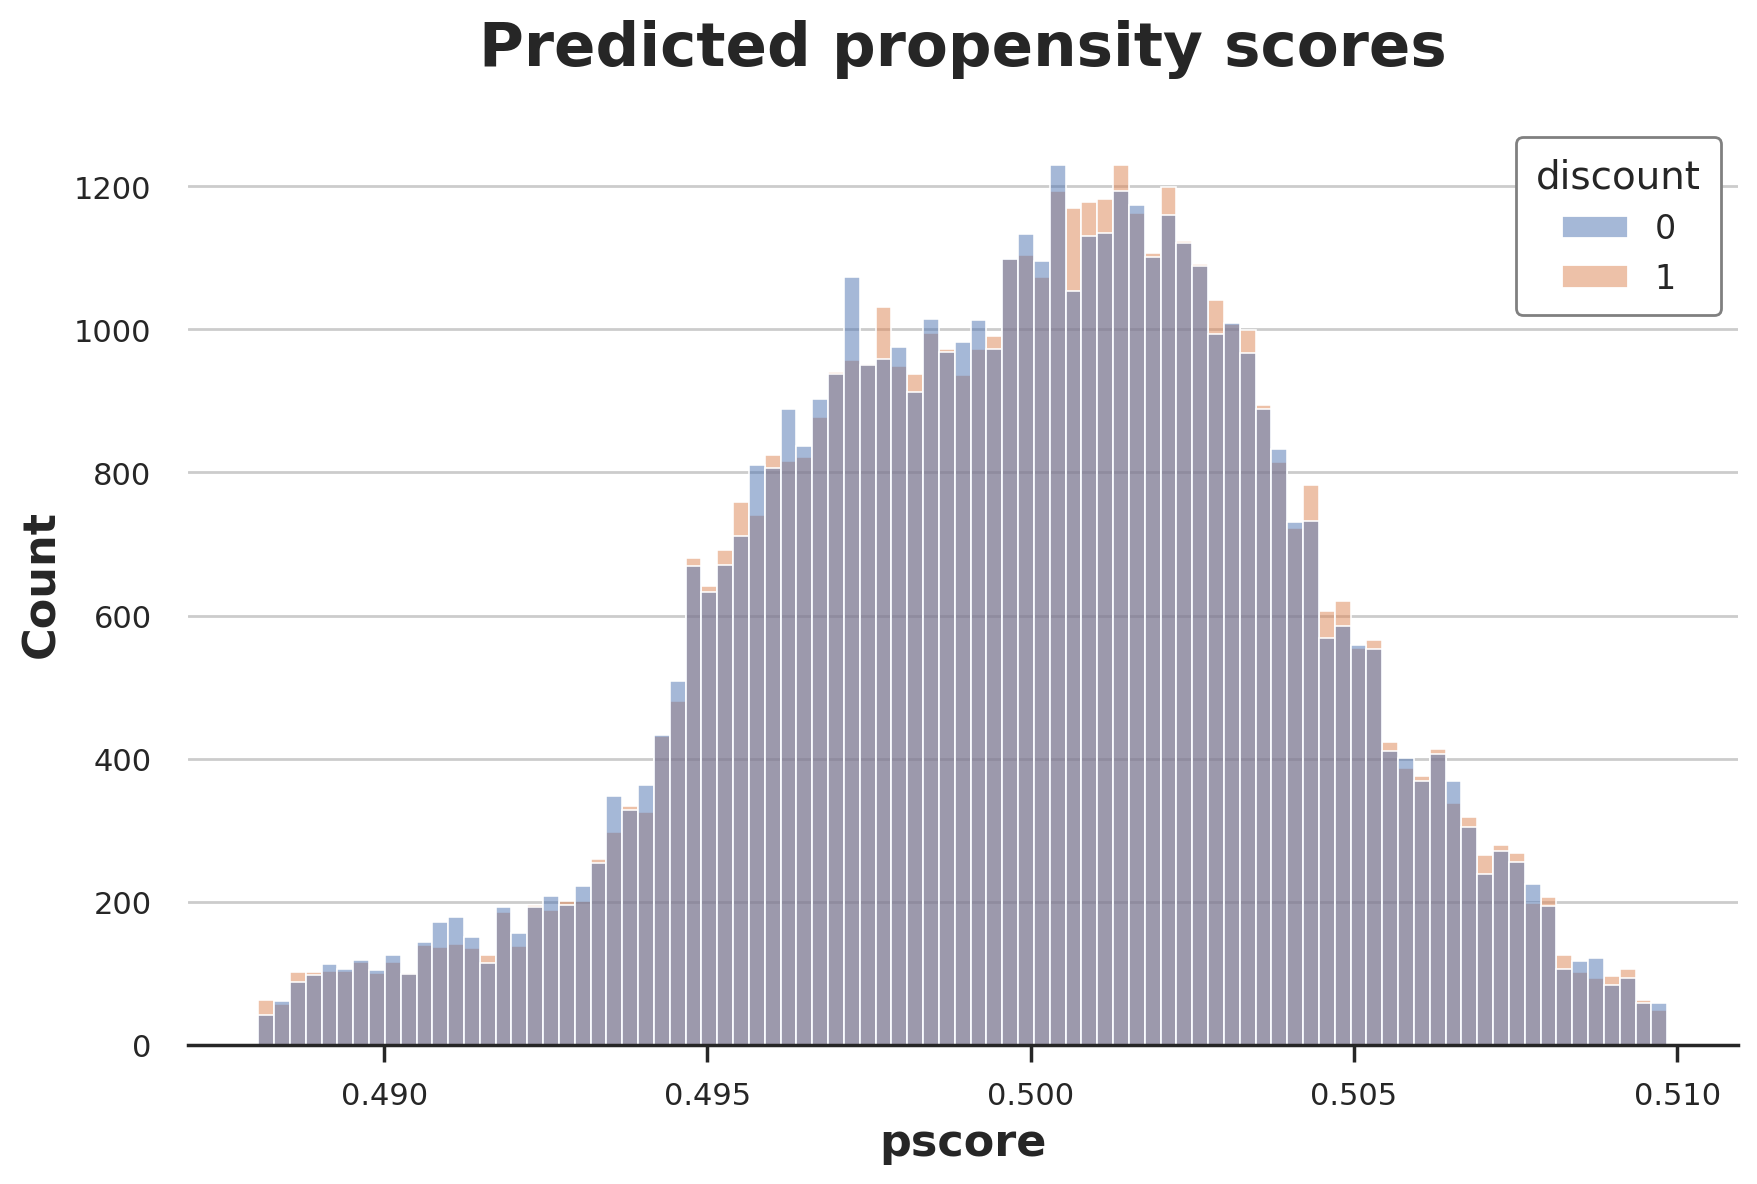

In [ ]:
from sklearn.linear_model import LogisticRegression
df['pscore'] = LogisticRegression().fit(df[X], df[dgp.D]).predict_proba(df[X])[:,1]
sns.histplot(data=df, x='pscore', hue='discount').set(title='Predicted propensity scores');

As expected, most propensity scores are very close to 0.5, the probability of treatment used in randomization.

We now have all the elements to compute our auxiliary outcome variable $Y^*$.

In [ ]:
df[dgp.Y[0]]

0         0.46
1        11.04
2         1.81
3        31.90
4        15.42
         ...  
99995    38.12
99996    17.95
99997    14.84
99998     0.20
99999     5.51
Name: spend, Length: 100000, dtype: float64

In [ ]:
df['y_star'] = df[dgp.Y[0]] / (df[dgp.D] * df['pscore'] - (1-df[dgp.D]) * (1-df['pscore']))

As we said before, the idea is to use $Y^*$ as the target of a prediction problem, since the expected value is exactly the individual treatment effect. Let's check its average in the data.

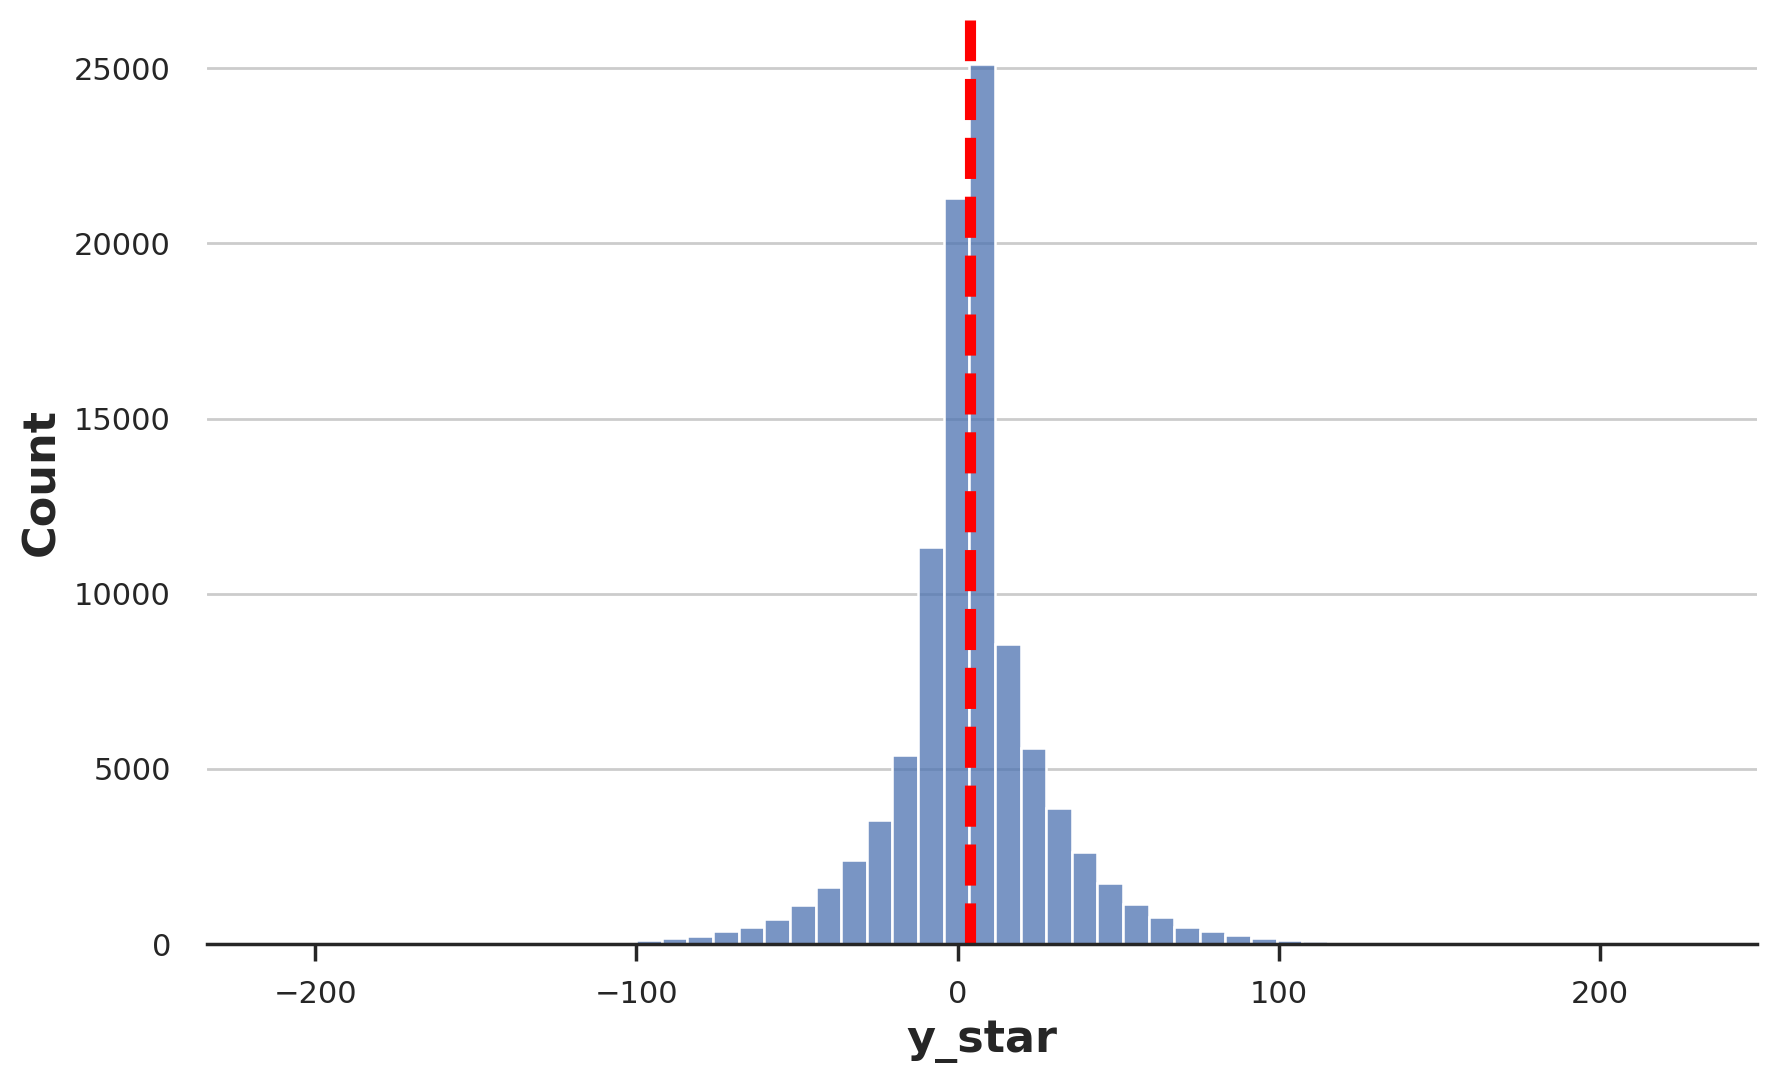

In [ ]:
sns.histplot(data=df, x='y_star', binwidth= 8)
plt.axvline(x=df['y_star'].mean(), color='red', linestyle='--')

Indeed its average is almost identical to the previously estimated average treatment effect of 3.85.

How is it possible that, with a single observation and an estimate of the propensity score, we can estimate the individual treatment effect? What are the drawbacks?

The **intuition** is to approach the problem from a different perspective: *ex-ante*, before the experiment. Imagine that our dataset had a single observation, $i$. We know that the treatment probability is $p(X_i)$, the propensity score. Therefore, in expectation, our dataset has $p(X_i)$ observations in the treatment group and $1 - p(X_i)$ observations in the control group. The rest is business as usual: we estimate the treatment effect as the difference in average outcomes between the two groups! And indeed that is what we would do:

$$
Y_i^* = \frac{Y_i D_i}{p(X_i)} - \frac{Y_i (1-D_i)}{1-p(X_i)}
$$

The only difference is that we have a single observation.

This trick comes at a cost: $Y_i^*$ is an unbiased estimator for the individual treatment effect, but has a very **high variance**. This is immediately visible by plotting its distribution.

In [ ]:

dgp.Y[0]

'spend'

<Axes: >

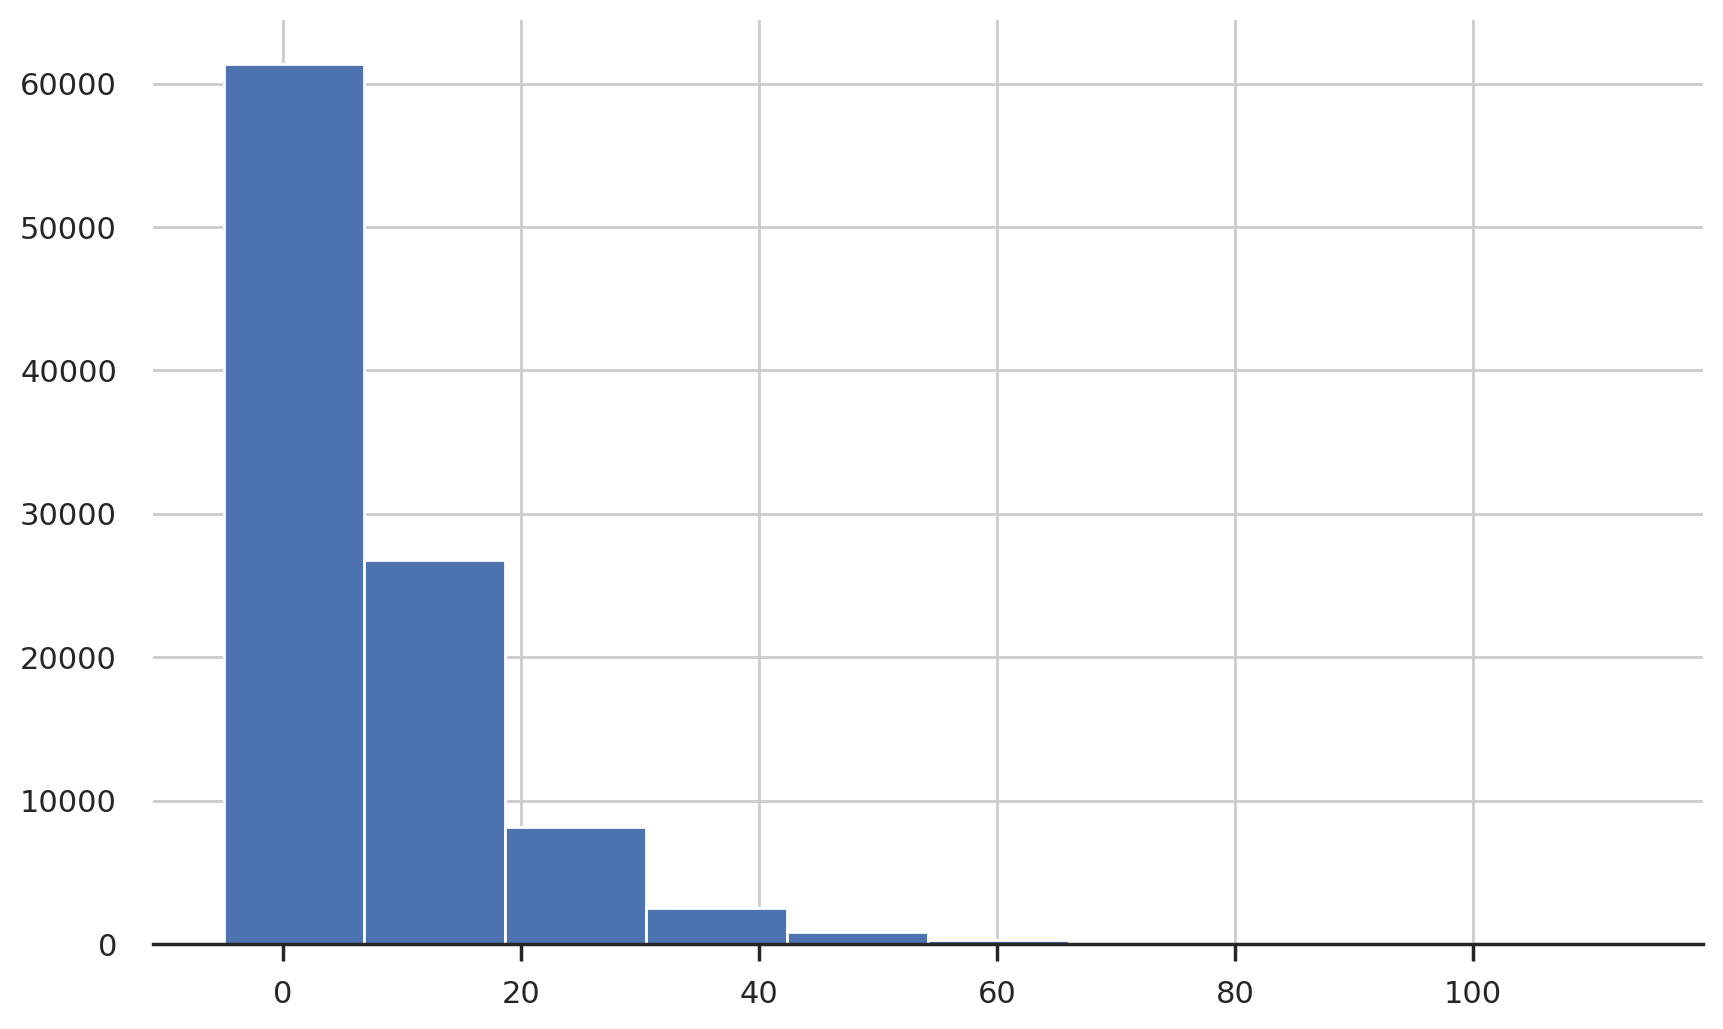

In [ ]:
df[dgp.Y[0]].hist()

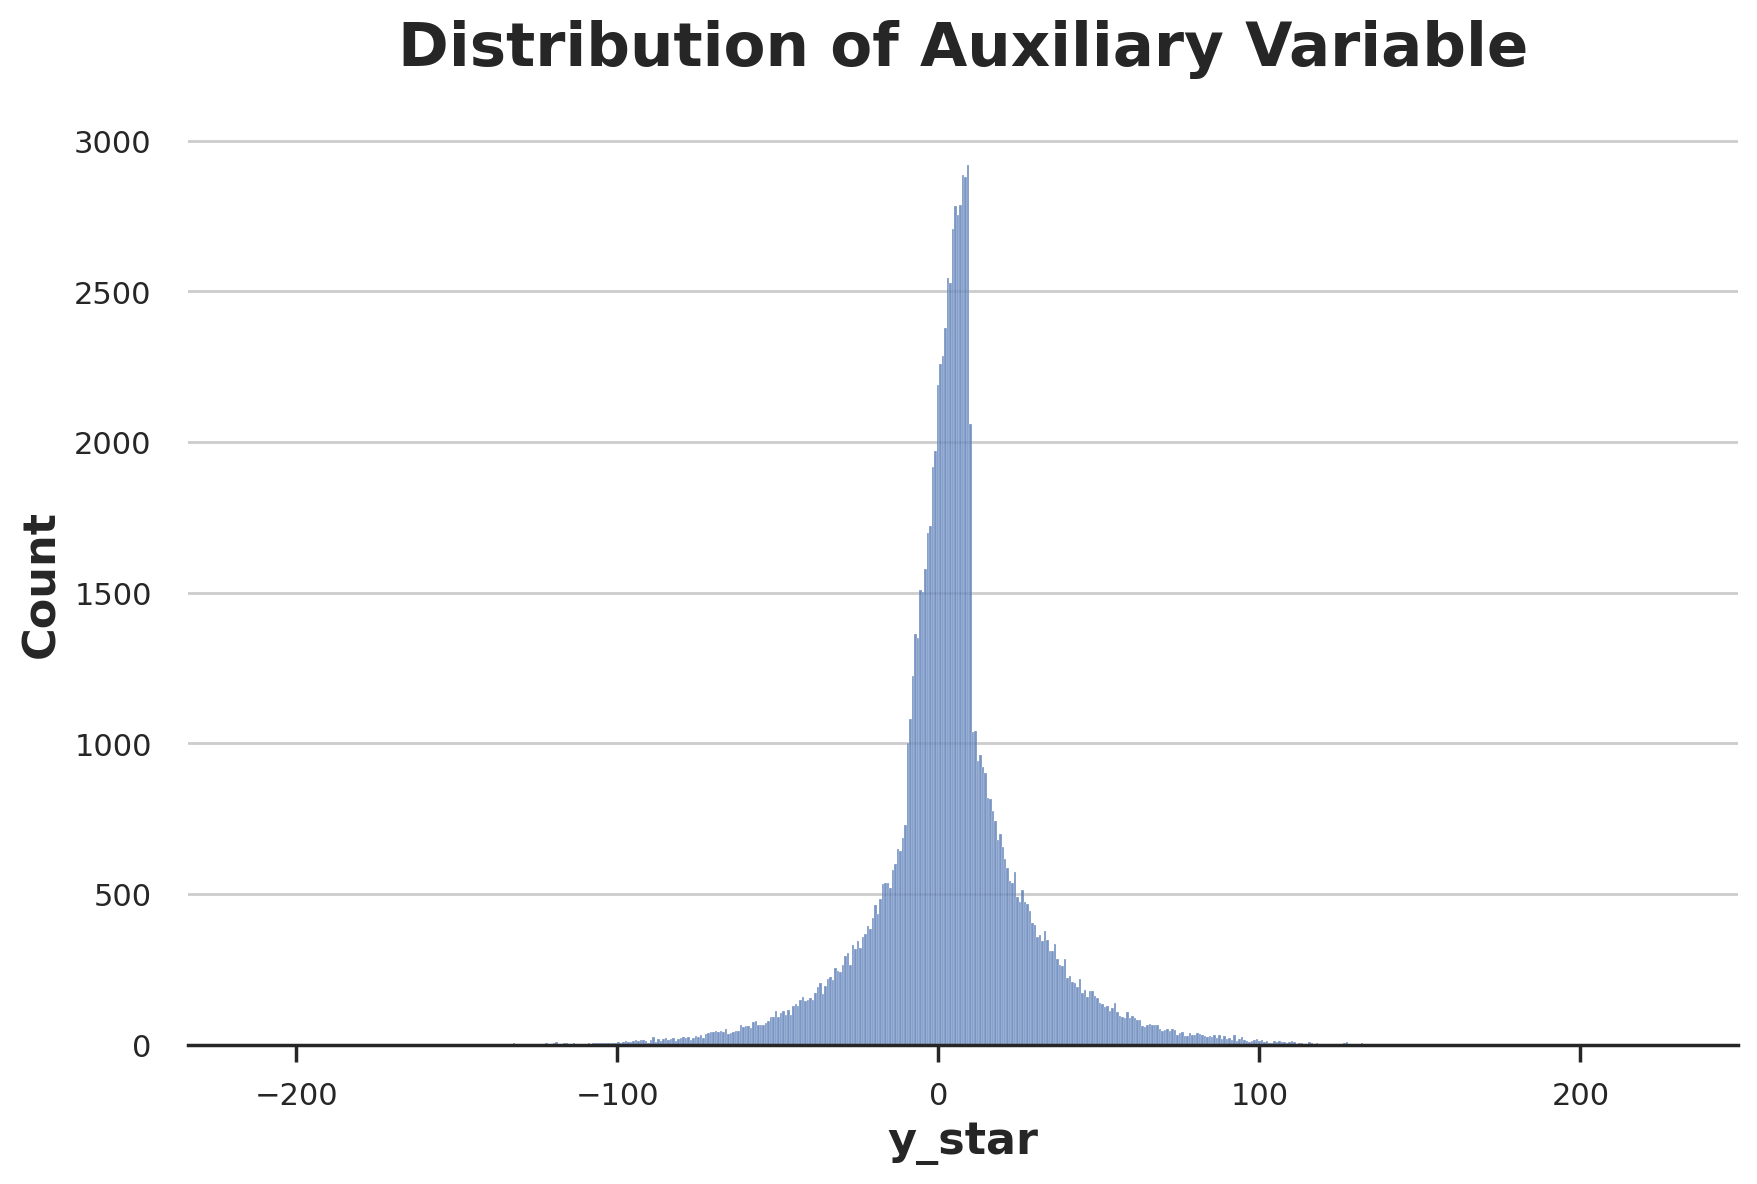

In [ ]:
sns.histplot(df['y_star']).set(title='Distribution of Auxiliary Variable');

We are now ready to estimate **heterogeneous treatment effects**, by translating the causal inference problem into a prediction problem, predicting the auxiliary outcome $Y^*$, given observable characteristics $X$.

## Causal Trees

In the previous section, we have see that we can transform the estimation of **heterogeneous treatment effects** into a prediction problem, where the outcome is the auxiliary outcome variable

$$
Y_i^* = \frac{Y_i}{T_i * e_i - (1-T_i) * (1-e_i)}
$$

We can in principle use any machine learning algorithm at this point to estimate individual treatment effects. However, [**regression trees**](https://en.wikipedia.org/wiki/Decision_tree_learning) have particularly convenient characteristics.

First of all, how do regression trees work? Without going too much in detail, they are an algorithm that recursively **partitions the data in bins** such that the outcome $Y$ *within* each bin is as homogeneous as possible and the outcome *across* bins is as heterogeneous as possible. The predicted values are simply the averages within each bin.

The **averaging** part is one of the big advantages of regression trees for inference since we know very well how to do inference with averages, with the [**Central Limit Theorem**](https://en.wikipedia.org/wiki/Central_limit_theorem). The second advantage is that trees are very **interpretable**, since we can directly plot the data partition as a tree structure. We will see more of this later. Last but not least, regression trees are still at the core the [best performing predictive algorithms](https://arxiv.org/abs/2207.08815) with tabular data, as of 2022.

Let's use the [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) function from `sklearn` to fit our regression tree and estimate heterogeneous treatment effects of `discounts` on customers' `spend`.

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=2).fit(df[X], df['y_star'])
df['y_hat'] = tree.predict(df[X])

We have restricted the tree to have a maximum depth of 2 and at least 30 observation per partition (also called *leaf*) so that we can easily plot the tree and visualize the estimated groups and treatment effects.

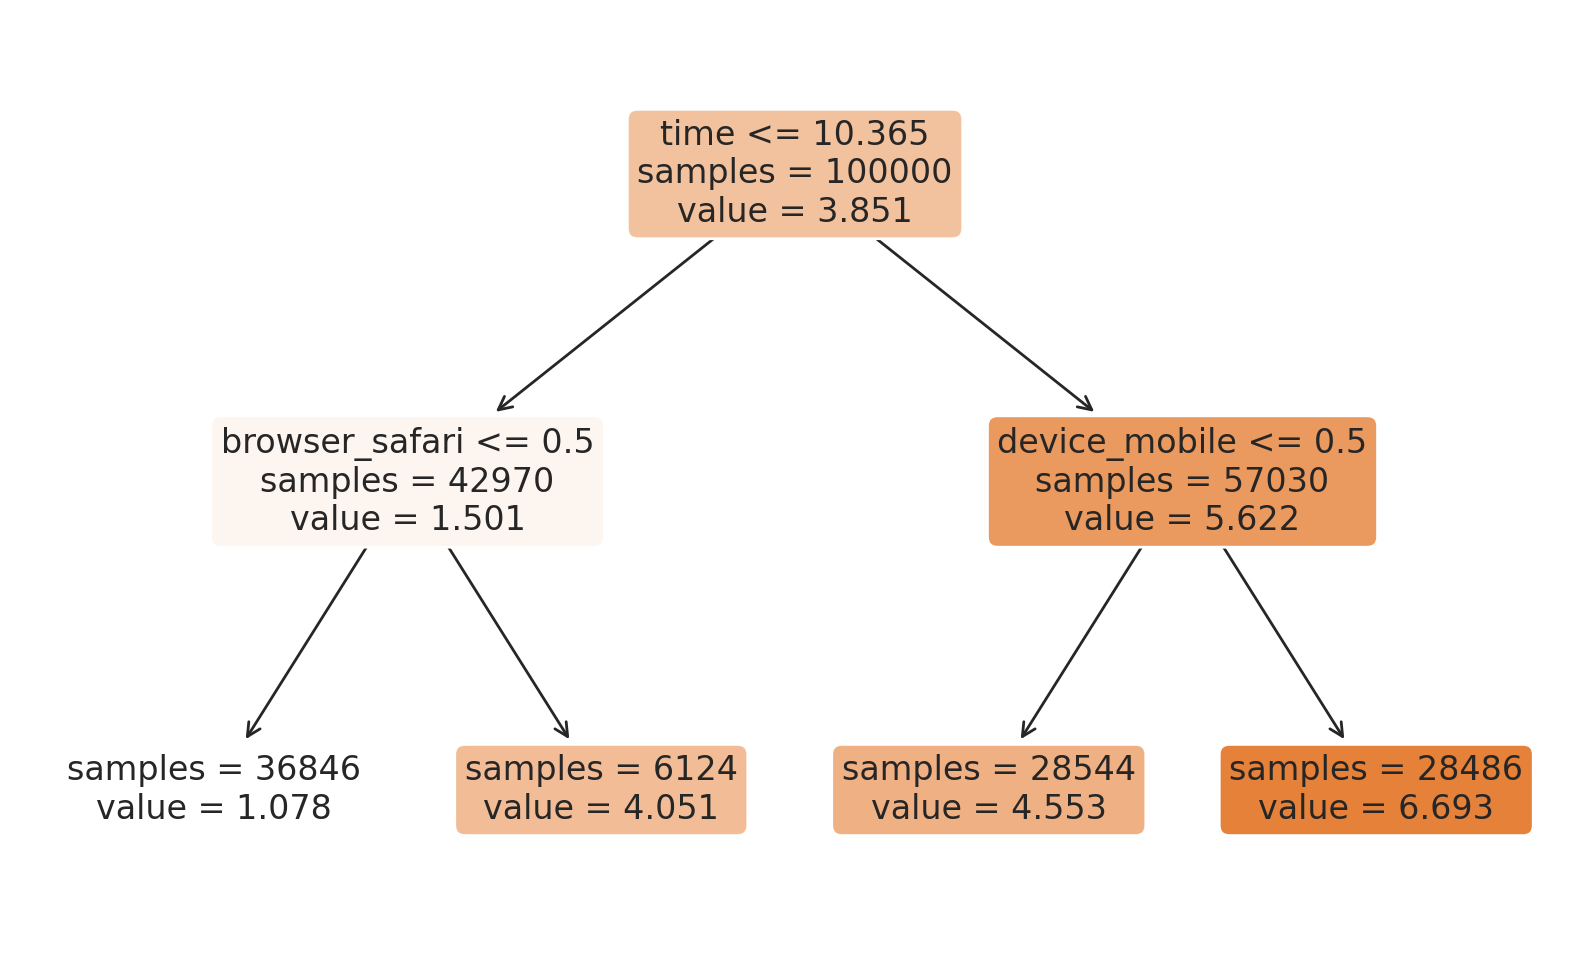

In [ ]:
from sklearn.tree import plot_tree

plot_tree(tree, filled=True, fontsize=12, feature_names=X, impurity=False, rounded=True);

How should we **interpret** the tree? On the top, we can see the average $Y^*$ in the data, 3.851. Starting from there, the data gets split into different branches, according to the rules highlighted at the top of each node. For example, the first node splits the data into two groups of size 42970 and 57030 depending on whether the `time` is later than 10.365. At the bottom, we have our final partitions, with the predicted values. For example, the leftmost leaf contains 36846 observation with `time` earlier than 10.365 and non-Safari `browser`, for which we predict a spend of 1.078. Darker node colors indicate higher prediction values.

Should we believe these estimates? Not really, because of a couple of reasons. The **first problem** is that we have an unbiased estimate of the average treatment effect only if, *within each leaf*, we have the same number of treated and control units. This is not automatically the case with an off-the-shelf `DecisionTreeRegressor()`.

Moreover, we have used the **same data** to generate the tree and evaluate it. This generates some bias because of overfitting. We can split the sample in 2 and use different data to generate the tree and compute the predictions. These trees are called **honest trees**.

Last but not least, how should the tree be generated? The default rule to generate splits with the `DecisionTreeRegressor` function is the `squared_error` and there is no restriction on the minimum number of observations per leaf. However, since we are interested in doing inference, we would like to have a sufficient sample size in each leaf to detect a treatment effect.

Luckily, there are multiple libraries where the so-called [**causal trees**](https://www.pnas.org/doi/abs/10.1073/pnas.1510489113) are implemented. We import `CausalForestDML` from Microsoft's [EconML](https://econml.azurewebsites.net/) library, one of the best libraries for causal inference.

In [ ]:
!pip install econml

In [ ]:
from econml.dml import CausalForestDML
np.random.seed(0)
tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3)
tree_model = tree_model.fit(Y=df[dgp.Y], X=df[X], T=df[dgp.D])

In [ ]:
tree_model

We have restricted the number of estimators to 1 to have a single tree instead of multiple ones, the so-called [**random forests**](https://en.wikipedia.org/wiki/Random_forest) that we will cover in a separate article.

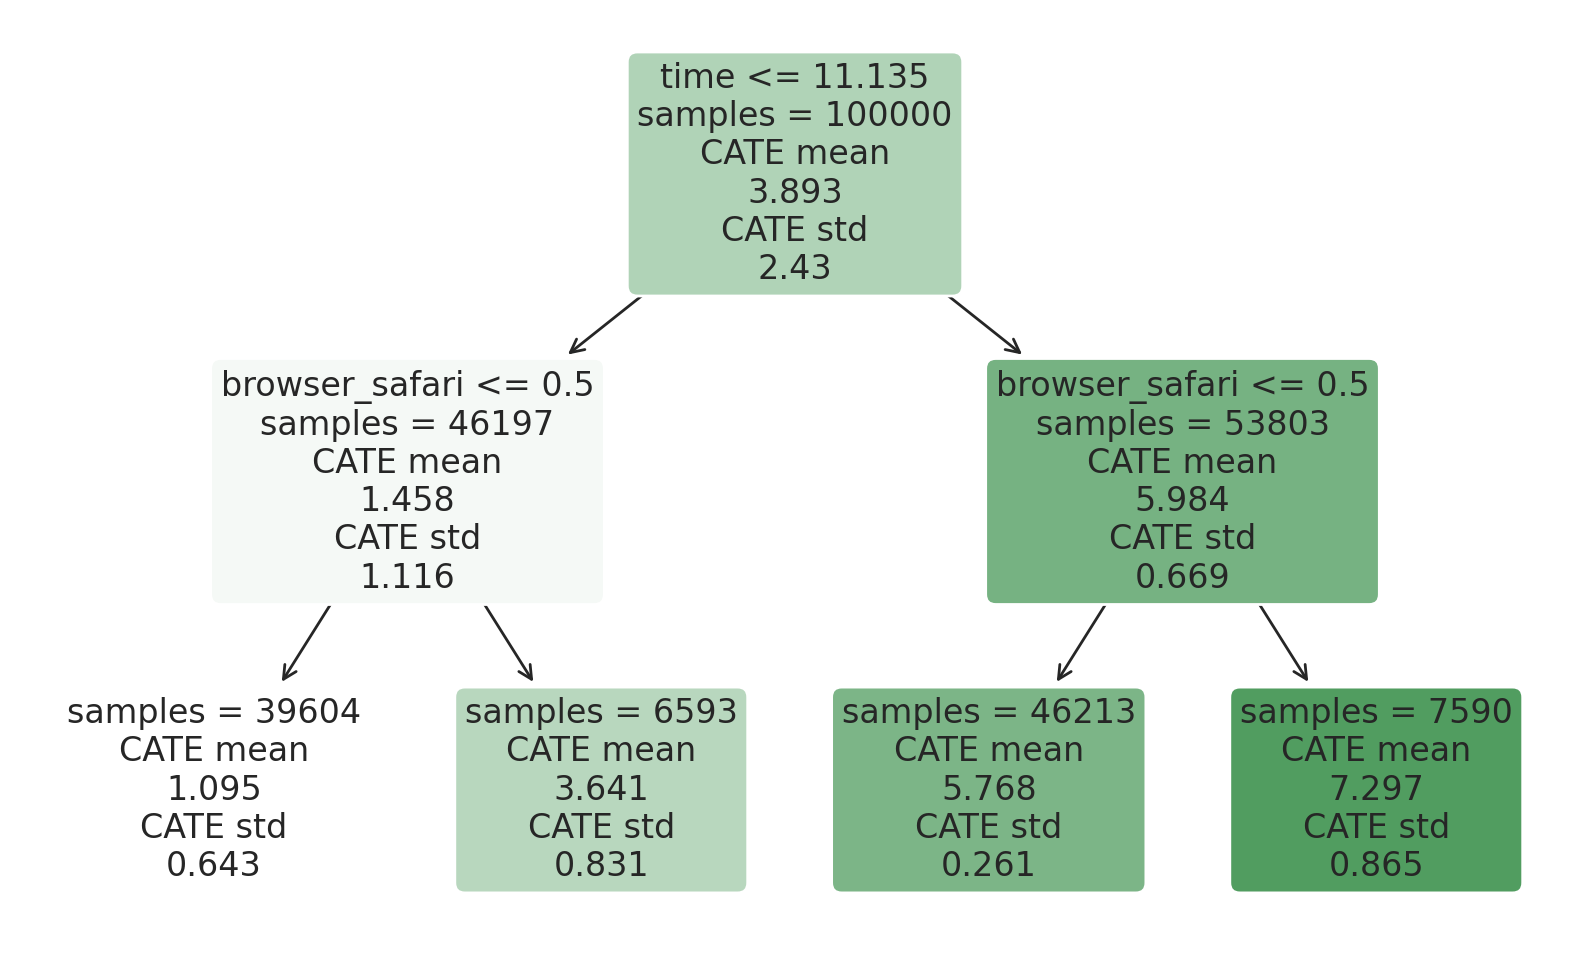

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, df[X])
intrp.plot(feature_names=X, fontsize=12)

As we can see, the tree representation looks extremely similar to the one we got before using the `DecisionTreeRegressor` function. However, now the model not only reports estimates of the conditional average treatment effects, but also the standard errors of the estimates (at the bottom). How were they computed?

### Inference

Honest trees, besides improving the out-of-sample prediction accuracy of the model, have another great implication: they allow us to **compute standard errors as if the tree structure was exogenous**. In fact, since the data used to compute the predictions is independent from the data used to build the tree (split the data), we can just treat the tree structure as independent from the estimated treatment effects. As a consequence, we can estimate the standard errors of the the estimates as standard errors of difference between sample averages, as in a standard AB test.

If we had used the same data to build the tree and estimate the treatment effects, we would have introduced **bias**, because of the spurious correlation between the covariates and the outcomes. This bias usually disappears for very large sample sizes, but honest trees do not require than.

### Performance

How well does the model perform? Since we control the data generating process, we can do something that is not possible with real data: check the predicted treatment effects against the true ones. The `generate_potential_outcomes()` function loads the data with both potential outcomes for each observation, under both treatment (`outcome_t`) and control (`outcome_c`).

In [ ]:
def compute_discrete_effects(df, hte_model):
    temp_df = df.copy()
    temp_df.time = 0
    temp_df = dgp.add_treatment_effect(temp_df)
    temp_df = temp_df.rename(columns={'effect_on_spend': 'True'})
    temp_df['Predicted'] = hte_model.effect(temp_df[X])
    df_effects = pd.DataFrame()
    for var in X[1:]:
        for effect in ['True', 'Predicted']:
            v = temp_df[effect][temp_df[var]==1].mean() - temp_df[effect][temp_df[var]==0].mean()
            effect_var = {'Variable': [var], 'Effect': [effect], 'Value': [v]}
            df_effects = pd.concat([df_effects, pd.DataFrame(effect_var)]).reset_index(drop=True)
    return df_effects, temp_df['Predicted'].mean()

In [ ]:
df_effects_tree, avg_effect_notime_tree = compute_discrete_effects(df, tree_model)

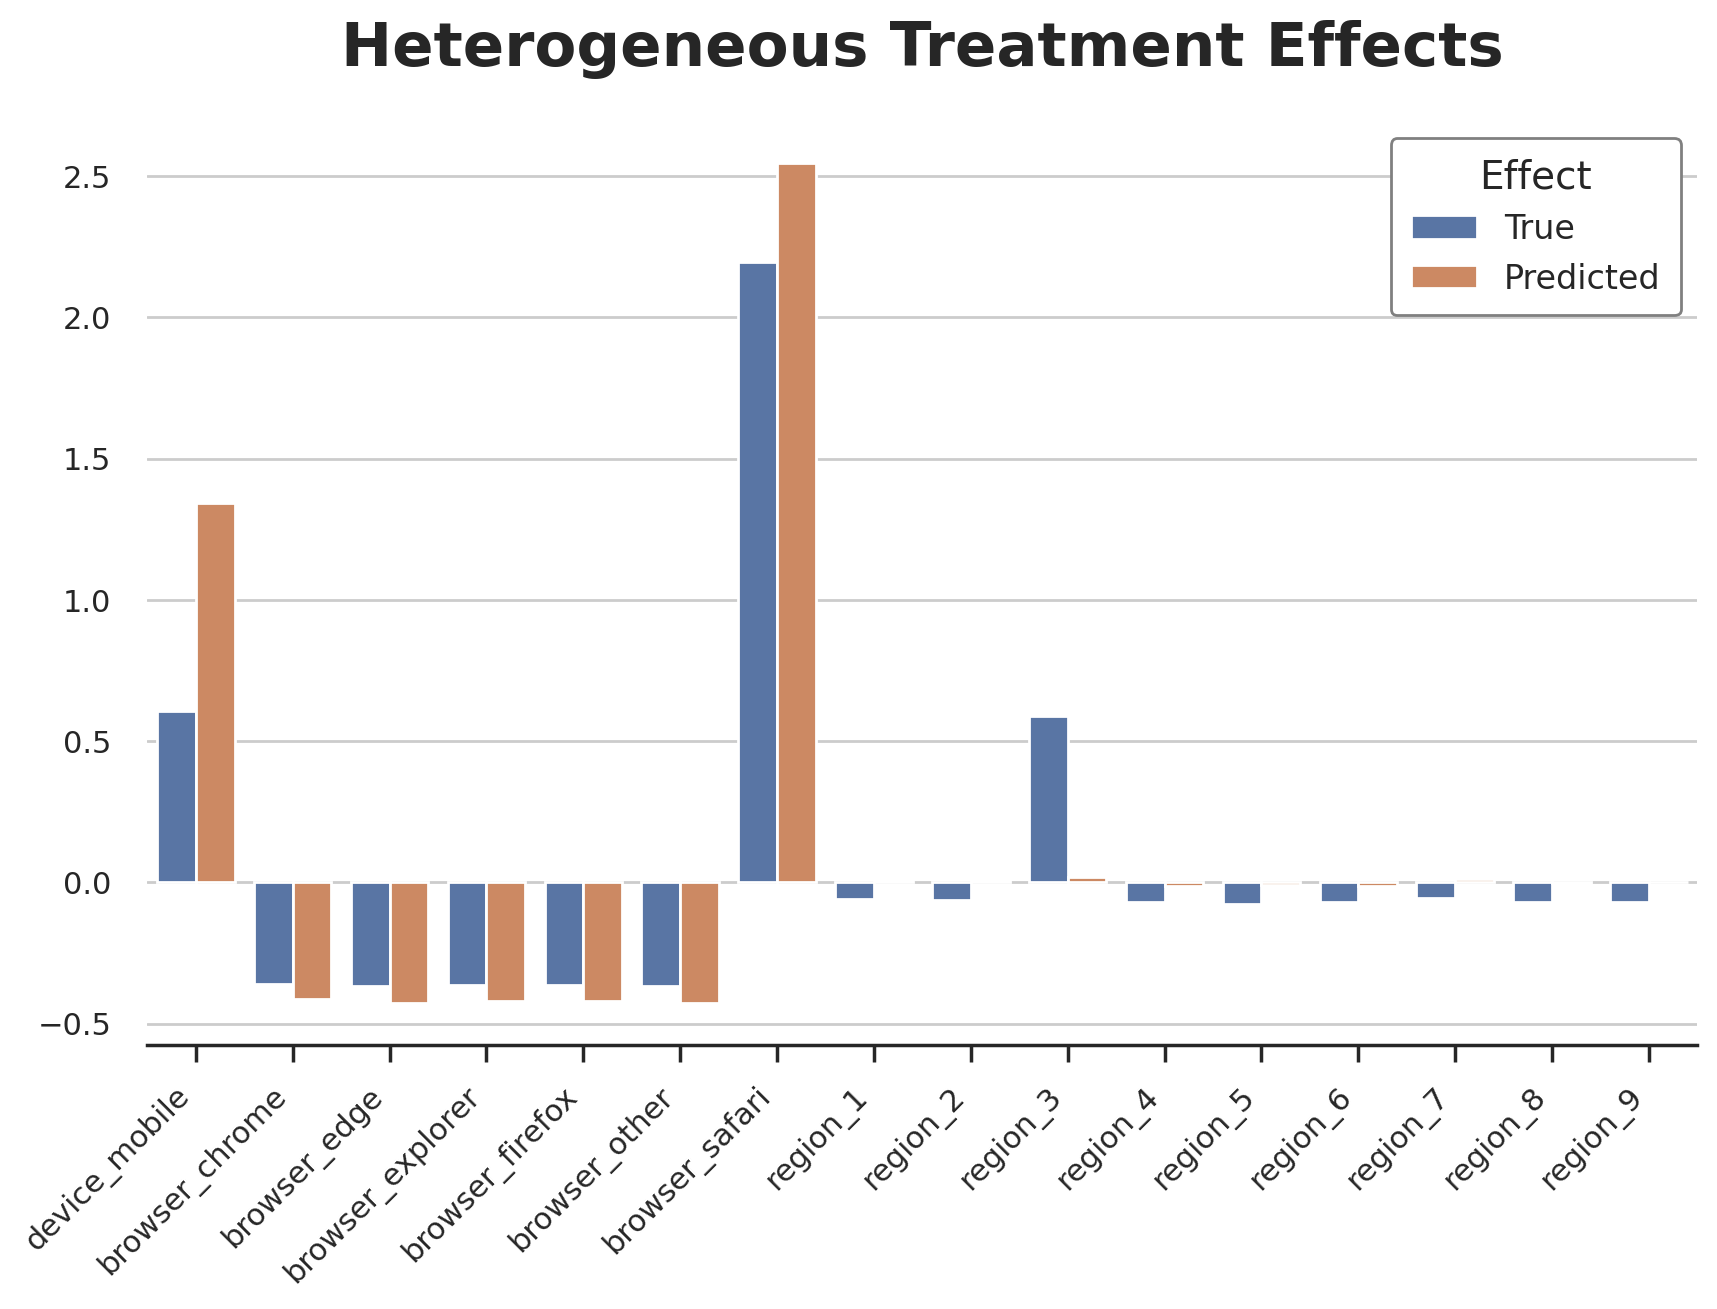

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=df_effects_tree, x="Variable", y="Value", hue="Effect", ax=ax).set(
    xlabel='', ylabel='', title='Heterogeneous Treatment Effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");

The causal tree is pretty good at detecting the heterogeneous treatment effects for the categorical variables. It only missed the heterogeneity in the third region.

However, this is also where we expect a tree model to perform particularly well: where the effects are **discrete**. How well does it do on our continuous variable, time? First, let's again isolate the predicted treatment effects on `time` and ignore the other covariates.

In [ ]:
def compute_time_effect(df, hte_model, avg_effect_notime):
    df_time = df.copy()
    df_time[[X[1:]] + ['device', 'browser', 'region']] = 0
    df_time = dgp.add_treatment_effect(df_time)
    df_time['predicted'] = hte_model.effect(df_time[X]) + avg_effect_notime
    return df_time

In [ ]:
df_time_tree = compute_time_effect(df, tree_model, avg_effect_notime_tree)

[texto del vínculo](https:// [texto del vínculo](https://))We now plot the predicted treatment effects against the true ones, along the `time` dimension.

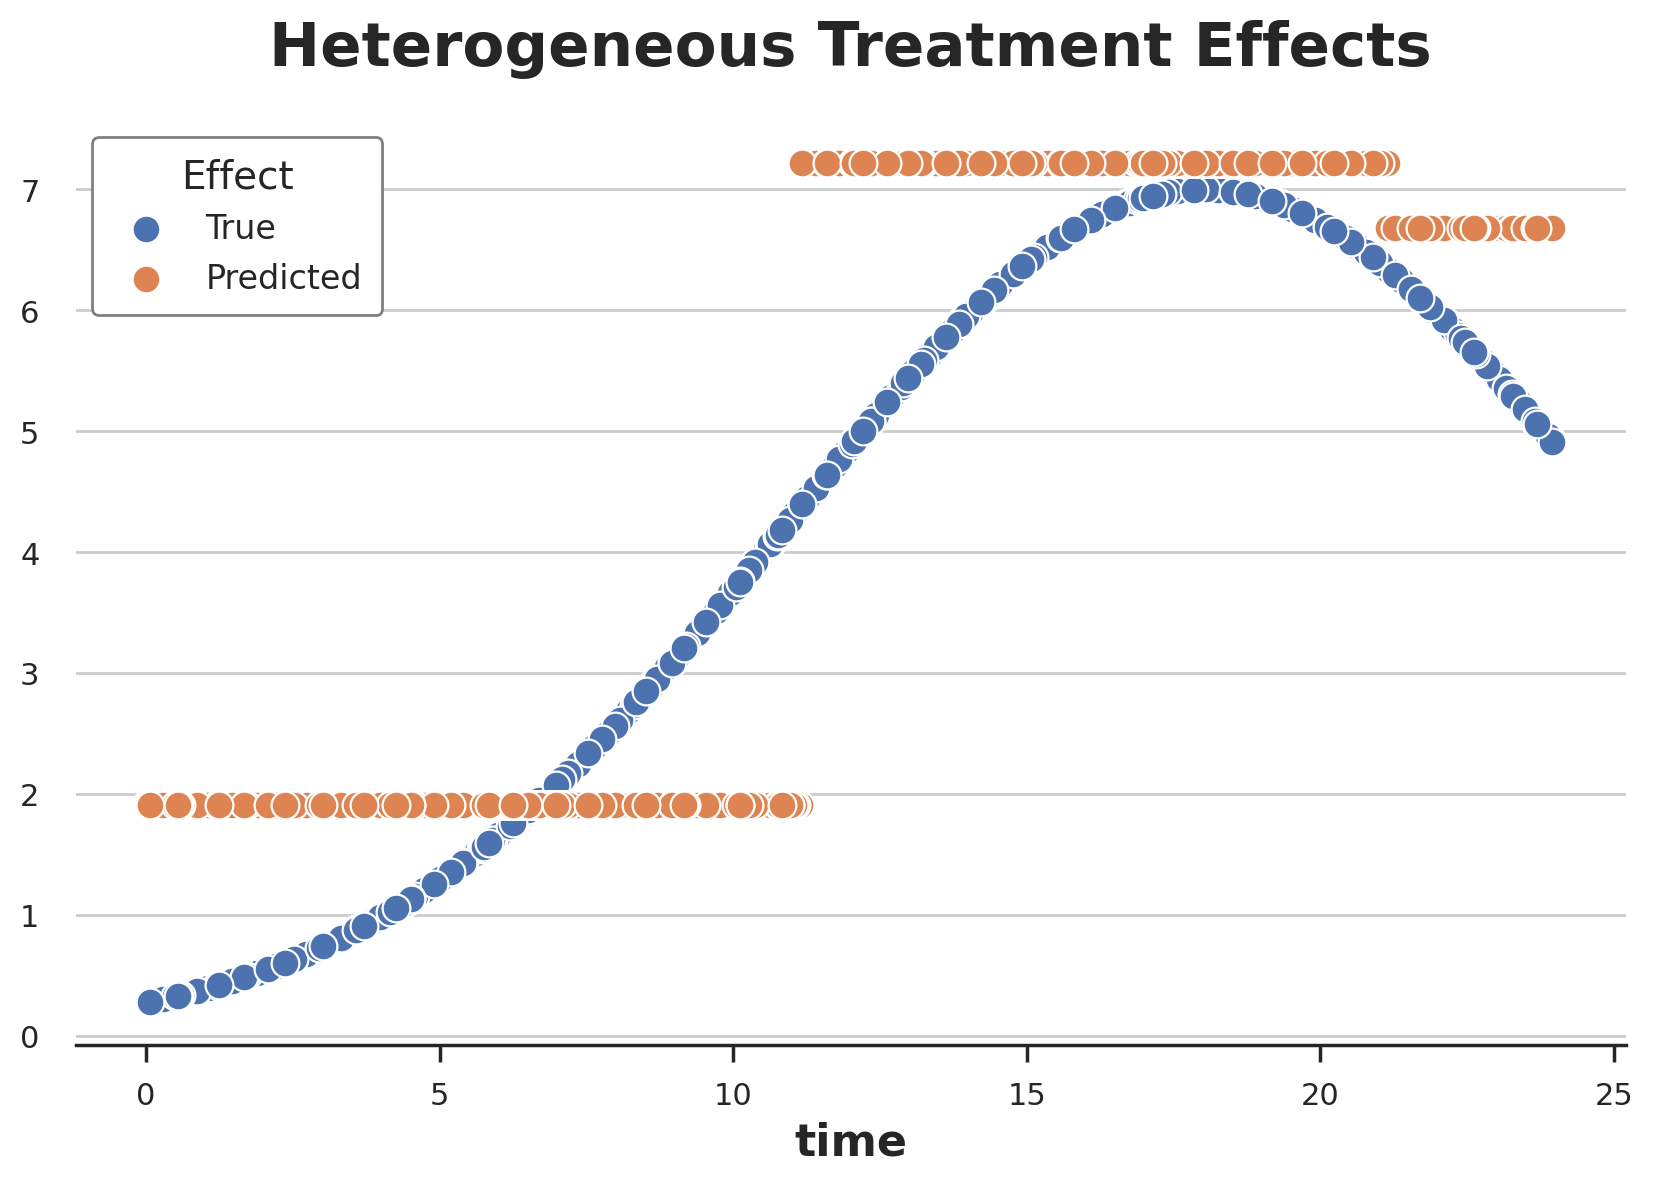

In [ ]:
sns.scatterplot( x='time', y='effect_on_spend', data=df_time_tree, label='True' )
sns.scatterplot(x='time', y='predicted', data=df_time_tree, label='Predicted').set(
    ylabel='', title='Heterogeneous Treatment Effects')
plt.legend(title='Effect');

In [ ]:
from econml.dml import CausalForestDML
np.random.seed(0)
tree_model = CausalForestDML(n_estimators=100, max_samples = 0.4, subforest_size =4, inference=True, max_depth=3)
tree_model = tree_model.fit(Y=quintiles_df[dgp.Y], X=quintiles_df[X_quintiles], T=quintiles_df[dgp.D])

In [ ]:
from econml.inference import PopulationSummaryResults

PopulationSummaryResults(tree_model)

TypeError: PopulationSummaryResults.__init__() missing 4 required positional arguments: 'pred_stderr', 'mean_pred_stderr', 'd_t', and 'd_y'

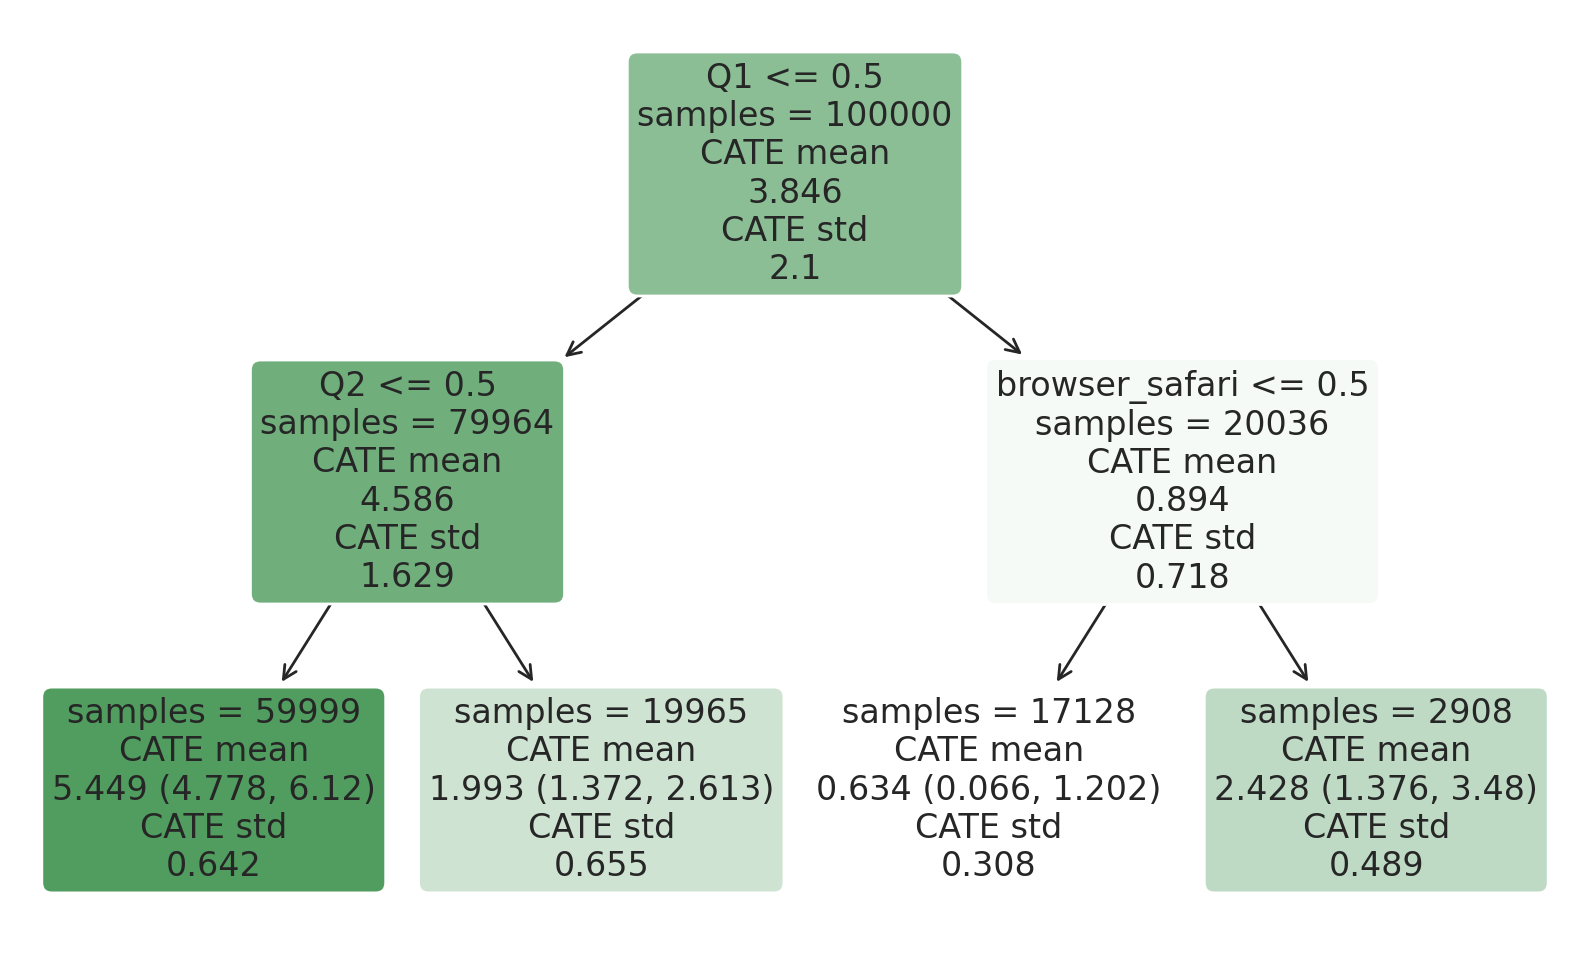

In [ ]:
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2, include_model_uncertainty=True ).interpret(tree_model, quintiles_df[X_quintiles])
intrp.plot(feature_names=X_quintiles, fontsize=12)

In [ ]:
X_quintiles = X[1:] + ['Q1', 'Q2', 'Q3', 'Q4', 'Q5']

In [ ]:
import pandas as pd

# Assuming df is your DataFrame and 'time' is the column of interest

# Calculate quintiles and create dummy variables
df['quintile'] = pd.qcut(df['time'], 5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
quintiles_dummies = pd.get_dummies(df['quintile'])
quintiles_df = pd.concat([df.drop('quintile', axis=1), quintiles_dummies], axis=1)

# Calculate deciles and create dummy variables
df['decile'] = pd.qcut(df['time'], 10, labels=[
    'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10'
])
deciles_dummies = pd.get_dummies(df['decile'])
deciles_df = pd.concat([df.drop('decile', axis=1), deciles_dummies], axis=1)

# Now you have `quintiles_df` and `deciles_df` with dummy variables for each category


<Axes: >

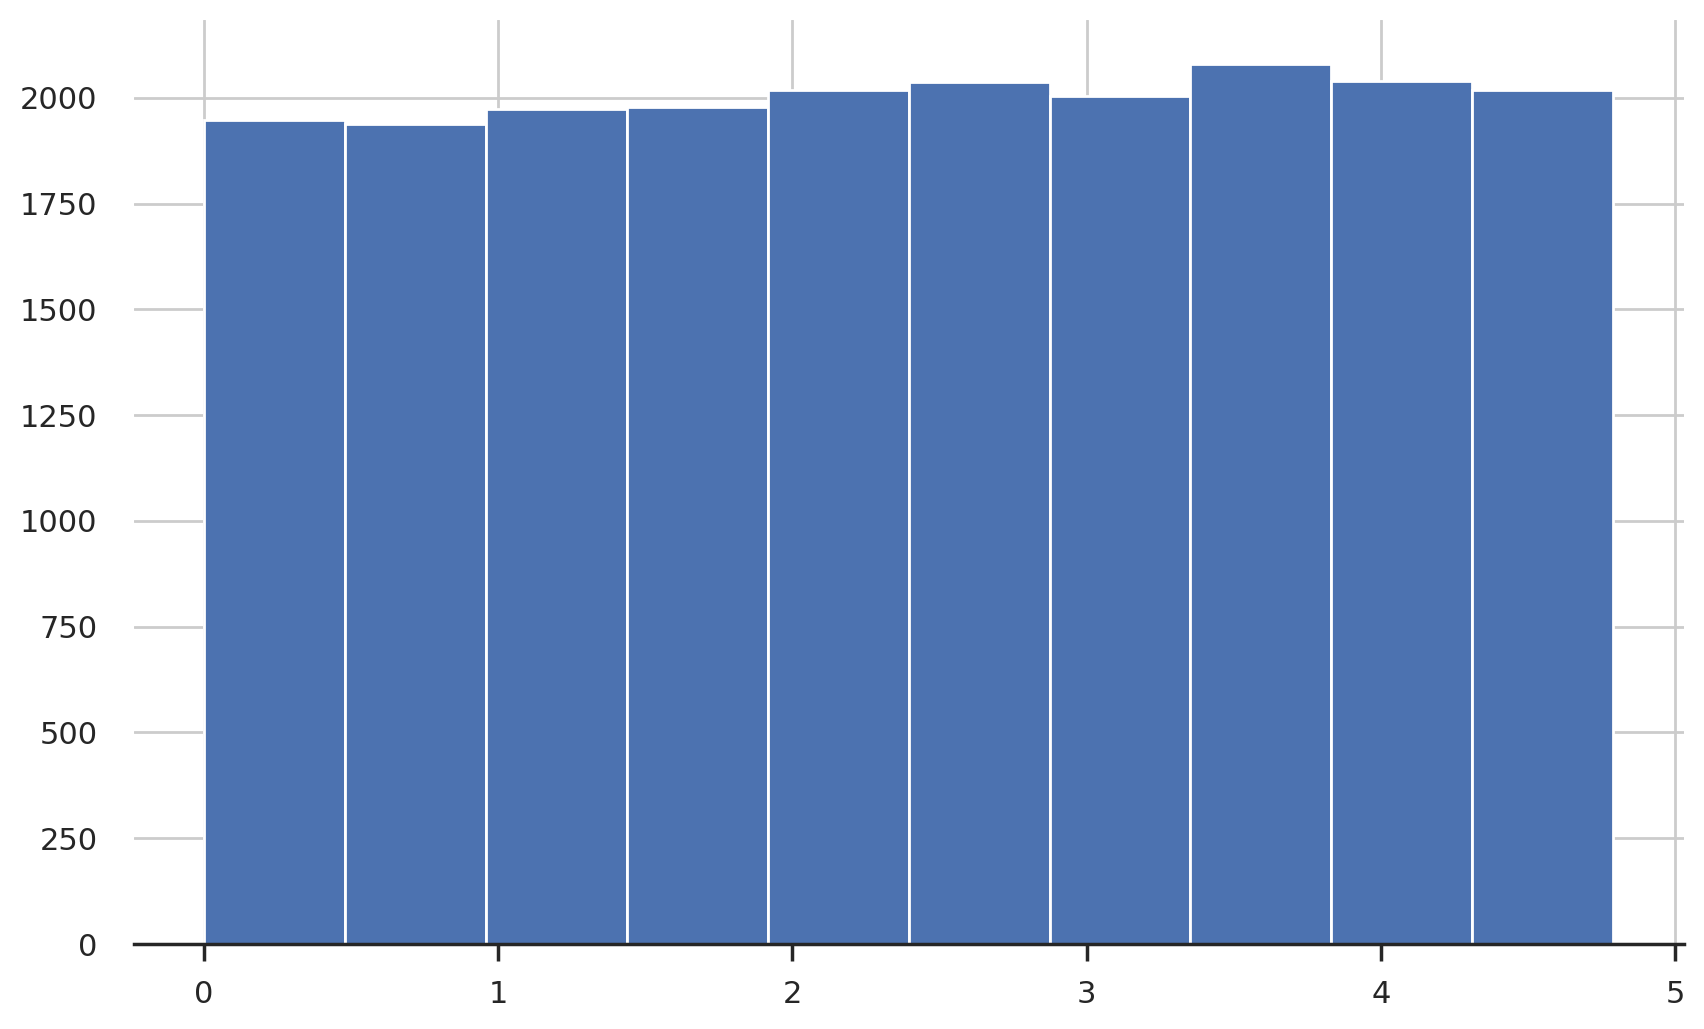

In [ ]:
df.query( "quintile == 'Q1'").time.hist()

From the plot, we can appreciate the discrete nature of causal trees: the model is only able to split the continuous variable into 5 bins. These bins are close to the true treatment effects, but they fail to capture a big chunk of the treatment effect heterogeneity.

Can these predictions be improved? The answer is yes, and we will explore how in the next post.

## Conclusion

In this article, we have seen how to use causal trees to estimate **heterogeneous treatment effects**. The main insight comes from the definition of an auxiliary outcome variable that allows us to frame the inference problem as a prediction problem. While we can then use any algorithm to predict treatment effects, regression trees are particularly useful because of their interpretability, prediction accuracy, and feature of generating prediction as subsample averages.

The work by [Athey and Imbens (2016)](https://www.pnas.org/doi/abs/10.1073/pnas.1510489113) on regression trees to compute heterogeneous treatment effects brought together two separate literatures, causal inference and machine learning in a very fruitful **synergy**. The causal inference literature (re)discovered the inference benefits of sample splitting, that allows us to do correct inference even when the data partition is complex and hard to analyze. On the other hand, splitting the tree generation phase from the within-leaf prediction phase has strong benefits in terms of prediction accuracy, by safeguarding against overfitting.

### References

- S. Athey, G. Imbens, [Recursive partitioning for heterogeneous causal effects](https://www.pnas.org/doi/abs/10.1073/pnas.1510489113) (2016), *PNAS*.

- S. Wager, S. Athey, [Estimation and Inference of Heterogeneous Treatment Effects using Random Forests](https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1319839) (2018), *Journal of the American Statistical Association*.

- S. Athey, J. Tibshirani, S. Wager, [Generalized Random Forests](https://projecteuclid.org/journals/annals-of-statistics/volume-47/issue-2/Generalized-random-forests/10.1214/18-AOS1709.full) (2019). *The Annals of Statistics*.

- M. Oprescu, V. Syrgkanis, Z. Wu, [Orthogonal Random Forest for Causal Inference](http://proceedings.mlr.press/v97/oprescu19a.html?ref=https://githubhelp.com) (2019). *Proceedings of the 36th International Conference on Machine Learning*.

### Related Articles

- [DAGs and Control Variables](https://towardsdatascience.com/b63dc69e3d8c)

- [Matching, Weighting, or Regression?](https://towardsdatascience.com/99bf5cffa0d9)

- [Understanding Meta Learners](https://towardsdatascience.com/8a9c1e340832)

- [Understanding AIPW, the Doubly-Robust Estimator](https://towardsdatascience.com/ed4097dab27a)

### Code

You can find the original Jupyter Notebook here:

https://github.com/matteocourthoud/Blog-Posts/blob/main/notebooks/causal_trees.ipynb

# Causal Forest

In [ ]:
from econml.dml import CausalForestDML

np.random.seed(0)
forest_model = CausalForestDML(max_depth=3, n_estimators=100)
forest_model = forest_model.fit(Y=df[dgp.Y], X=df[X], T=df[dgp.D])

## Feature Importance

In [ ]:
fig, ax = plt.subplots()
sns.barplot(x=X, y=forest_model.feature_importances()[0], color='C0').set(
    title='Feature Importances', ylabel='Importance')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


## Performance

In [ ]:
def compute_discrete_effects(df, hte_model):
    temp_df = df.copy()
    temp_df.time = 0
    temp_df = dgp.add_treatment_effect(temp_df)
    temp_df = temp_df.rename(columns={'effect_on_spend': 'True'})
    temp_df['Predicted'] = hte_model.effect(temp_df[X])
    df_effects = pd.DataFrame()
    for var in X[1:]:
        for effect in ['True', 'Predicted']:
            v = temp_df.loc[temp_df[var]==1, effect].mean() - temp_df[effect][temp_df[var]==0].mean()
            effect_var = {'Variable': [var], 'Effect': [effect], 'Value': [v]}
            df_effects = pd.concat([df_effects, pd.DataFrame(effect_var)]).reset_index(drop=True)
    return df_effects, temp_df['Predicted'].mean()

df_effects, avg_effect_notime = compute_discrete_effects(df, forest_model)

In [ ]:
fig, ax = plt.subplots()
sns.barplot(data=df_effects, x="Variable", y="Value", hue="Effect", ax=ax).set(
    xlabel='', ylabel='', title='Heterogeneous Treatment Effects')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");



```
# Esto tiene formato de código
```

## Continuous Variable

In [ ]:
def compute_time_effect(df, hte_model, avg_effect_notime):
    df_time = df.copy()
    df_time[[X[1:]] + ['device', 'browser', 'region']] = 0
    df_time = dgp.add_treatment_effect(df_time)
    df_time['predicted'] = hte_model.effect(df_time[X]) + avg_effect_notime
    return df_time

df_time = compute_time_effect(df, forest_model, avg_effect_notime)

In [ ]:
sns.scatterplot(x='time', y='effect_on_spend', data=df_time, label='True')
sns.scatterplot(x='time', y='predicted', data=df_time, label='Predicted').set(
    ylabel='', title='Heterogeneous Treatment Effects')
plt.legend(title='Effect');